# Model Training and evaluation

In this notebook, we are going to train six models: three for linear/quadratic methods and three for non-linear methods.

In [57]:
# Uncomment to upgrade packages
# !pip3 install pandas --upgrade --quiet
# !pip3 install numpy --upgrade --quiet
# !pip3 install scipy  --upgrade --quiet
# !pip3 install statsmodels  --upgrade --quietq
# !pip3 install seaborn  --upgrade --quiet
# !pip3 install matplotlib  --upgrade --quiet
# !pip3 install scikit-learn  --upgrade
# !pip install scikit-optimize  --quiet
!pip install apafib --upgrade  --quiet
!pip install scikit-optimize --quiet
!pip install dtreeviz --quiet
!pip install pmlb --upgrade  --quiet

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import display, HTML
show_html = lambda html: display(HTML(html))

from time import time
from datetime import timedelta

init_time = time()

In [108]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import display, HTML
show_html = lambda html: display(HTML(html))

from time import time
from datetime import timedelta

init_time = time()
import pandas as pd
from pandas import read_csv

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn import set_config

from sklearn.metrics import  ConfusionMatrixDisplay,\
                  classification_report,  RocCurveDisplay, PrecisionRecallDisplay,\
                    accuracy_score, f1_score, precision_score, recall_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB, GaussianNB, CategoricalNB, MultinomialNB

from sklearn.model_selection import GridSearchCV

from yellowbrick.target.feature_correlation import feature_correlation
from yellowbrick.classifier import precision_recall_curve
from sklearn.inspection import permutation_importance

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import set_config
from sklearn.decomposition import PCA
from sklearn.ensemble import (BaggingClassifier, ExtraTreesClassifier,
                              GradientBoostingClassifier,
                              RandomForestClassifier, StackingClassifier,
                              VotingClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (ConfusionMatrixDisplay, PrecisionRecallDisplay,
                             RocCurveDisplay, accuracy_score,
                             classification_report, f1_score, make_scorer,
                             roc_auc_score)
from sklearn.model_selection import (GridSearchCV, cross_val_score,
                                     train_test_split)
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from skopt import BayesSearchCV
from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier.rocauc import roc_auc
from sklearn.svm import SVC

np.int = int # fix for skopt
import warnings

import dtreeviz
from apafib import load_attrition
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.under_sampling import RandomUnderSampler

import pandas as pd
import os
import sys
import os
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" # Also affect subprocesses

set_config(display='text')
warnings.filterwarnings('ignore')
plt.rcParams.update({'font.size': 16})
pd.set_option('display.precision', 3)


def save_results(clf, X_test, y_test, nclf, df):
    if hasattr(clf, 'best_score_'):
        df.loc[nclf,'train XV acc'] = clf.best_score_
    else:
        df.loc[nclf,'train XV acc'] = np.nan
    df.loc[nclf,'test acc'] = accuracy_score(y_test, clf.predict(X_test))
    df.loc[nclf,'precision score (M)'] = precision_score(y_test, clf.predict(X_test), average='macro')
    df.loc[nclf,'recall score (M)'] = recall_score(y_test, clf.predict(X_test), average='macro')
    df.loc[nclf,'f1 score (M)'] = f1_score(y_test, clf.predict(X_test), average='macro')
    return df

results_df = pd.DataFrame()

niter = 15
cv = 5

## Linear/Quadratic Methods

In [59]:
files = {
    "X_train": "X_train.csv",
    "y_train": "y_train.csv",
    "X_test": "X_test.csv",
    "y_test": "y_test.csv",
}

data = {}

# Load the data
for key, filename in files.items():
    filepath = os.path.join('data/', filename)
    try:
        data[key] = pd.read_csv(filepath)
        print(f"{key} loaded successfully. Shape: {data[key].shape}")
    except FileNotFoundError:
        print(f"Error: The file '{filepath}' was not found.")
    except pd.errors.EmptyDataError:
        print(f"Error: The file '{filepath}' is empty.")
    except Exception as e:
        print(f"Error loading '{filepath}': {e}")

X_train = data.get("X_train")
y_train = data.get("y_train")
X_test = data.get("X_test")
y_test = data.get("y_test")

if any(df is None for df in [X_train, y_train, X_test, y_test]):
    print("Some files could not be loaded. Please check the errors above.")
else:
    print("All files loaded successfully.")

X_train loaded successfully. Shape: (7000, 34)
y_train loaded successfully. Shape: (7000, 1)
X_test loaded successfully. Shape: (3000, 34)
y_test loaded successfully. Shape: (3000, 1)
All files loaded successfully.


In [60]:
target_names = [str(v) for v in sorted(y_train['IncidentGrade'].unique())]
print(f"Target names: {target_names}")

Target names: ['BenignPositive', 'FalsePositive', 'TruePositive']


In [61]:
# Reshape y_train and y_test to be 1-dimensional arrays if they are DataFrames
if isinstance(y_train, pd.DataFrame):
    y_train = y_train.values.ravel()
if isinstance(y_test, pd.DataFrame):
    y_test = y_test.values.ravel()

### Naïve Bayes
[EXPLICATION OF WHY NAIVE BAYES]

In [62]:
multinomialNB = MultinomialNB()
multinomialNB.best_score_ = np.mean(cross_val_score(multinomialNB,X_train,y_train,cv=10))
print(multinomialNB.best_score_)

0.5599999999999999


In [63]:
gnb = GaussianNB()
gnb.best_score_ = np.mean(cross_val_score(gnb,X_train,y_train,cv=10))
print(gnb.best_score_)

0.41142857142857137


In [64]:
bnb = BernoulliNB()
bnb.best_score_ = np.mean(cross_val_score(bnb,X_train,y_train,cv=10))
print(bnb.best_score_)


0.5841428571428572


In [65]:
mnb_model = MultinomialNB().fit(X_train, y_train)
gnb_model = GaussianNB().fit(X_train, y_train)
bnb_model = BernoulliNB().fit(X_train, y_train)


In [66]:
print('MultinomialNB')
print(classification_report(y_test, mnb_model.predict(X_test), target_names=target_names))
results_df = save_results(mnb_model, X_test, y_test, 'MNB', results_df)
print('GaussianNB')
print(classification_report(y_test, gnb_model.predict(X_test), target_names=target_names))
results_df = save_results(gnb_model, X_test, y_test, 'GNB', results_df)
print('BernoulliNB')
print(classification_report(y_test, bnb_model.predict(X_test), target_names=target_names))


MultinomialNB
                precision    recall  f1-score   support

BenignPositive       0.51      0.94      0.66      1268
 FalsePositive       0.00      0.00      0.00       653
  TruePositive       0.73      0.43      0.54      1079

      accuracy                           0.55      3000
     macro avg       0.41      0.46      0.40      3000
  weighted avg       0.48      0.55      0.47      3000

GaussianNB
                precision    recall  f1-score   support

BenignPositive       0.42      1.00      0.59      1268
 FalsePositive       0.00      0.00      0.00       653
  TruePositive       0.00      0.00      0.00      1079

      accuracy                           0.42      3000
     macro avg       0.14      0.33      0.20      3000
  weighted avg       0.18      0.42      0.25      3000

BernoulliNB
                precision    recall  f1-score   support

BenignPositive       0.52      1.00      0.69      1268
 FalsePositive       0.62      0.02      0.05       653
  Tr

MultinomialNB
GaussianNB
BernoulliNB


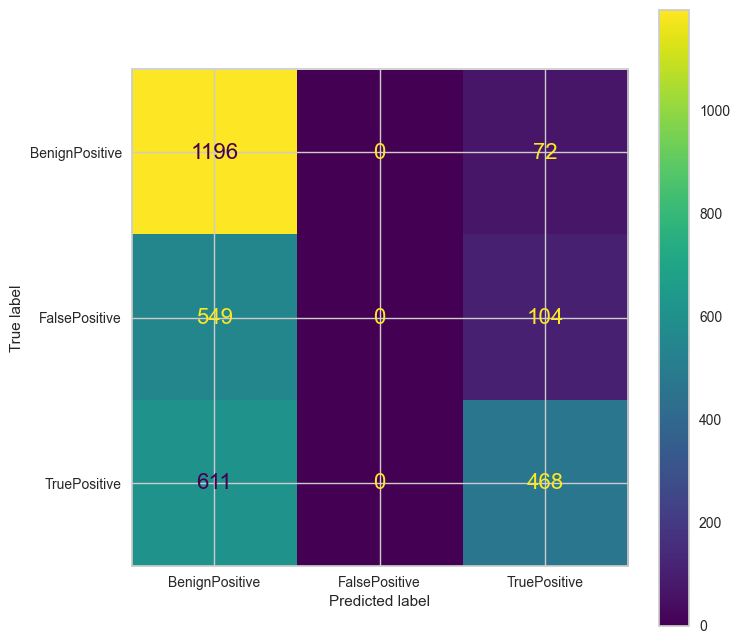

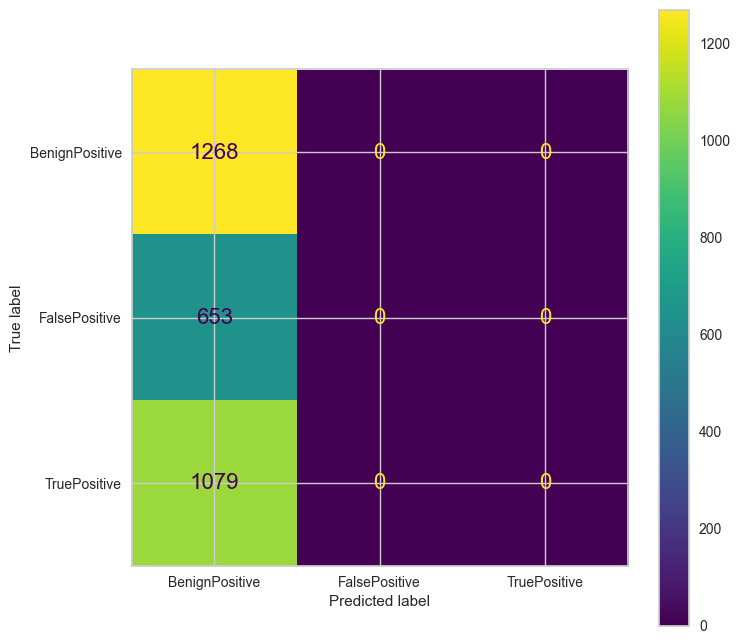

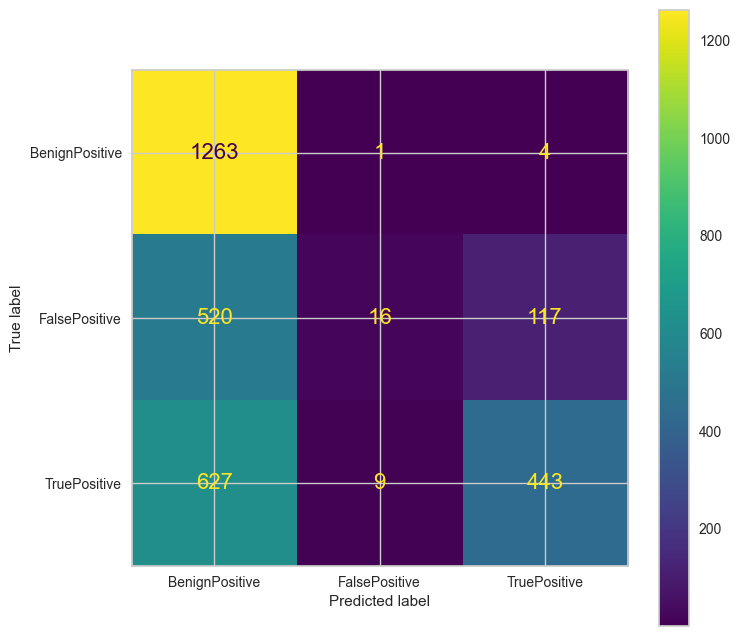

In [67]:
plt.figure(figsize=(8,8));
print('MultinomialNB')
ConfusionMatrixDisplay.from_estimator(mnb_model, X_test,y_test, display_labels=target_names, ax=plt.subplot());
plt.figure(figsize=(8,8));
print('GaussianNB')
ConfusionMatrixDisplay.from_estimator(gnb_model, X_test,y_test, display_labels=target_names, ax=plt.subplot());
plt.figure(figsize=(8,8));
print('BernoulliNB')
ConfusionMatrixDisplay.from_estimator(bnb_model, X_test,y_test, display_labels=target_names, ax=plt.subplot());

### Logistic Regression
[EXPLICATION OF WHY LOGISTIC REGRESSION]

In [68]:
lr= LogisticRegression(max_iter=10000)
param = {'penalty':['l1', 'l2'], 'C':10**np.linspace(-3,3,21, endpoint=True)}
lr_gs =  GridSearchCV(lr,param,cv=10, n_jobs=-1, refit=True)
lr_gs.fit(X_train, y_train); # need to convert vector of column to array of 1d

In [69]:
show_html(pd.DataFrame(lr_gs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
23,"{'C': 1.9952623149688788, 'penalty': 'l2'}",0.622,1
33,"{'C': 63.0957344480193, 'penalty': 'l2'}",0.622,1
25,"{'C': 3.9810717055349696, 'penalty': 'l2'}",0.622,3
31,"{'C': 31.622776601683796, 'penalty': 'l2'}",0.622,4
39,"{'C': 501.1872336272725, 'penalty': 'l2'}",0.622,4


Coefs:


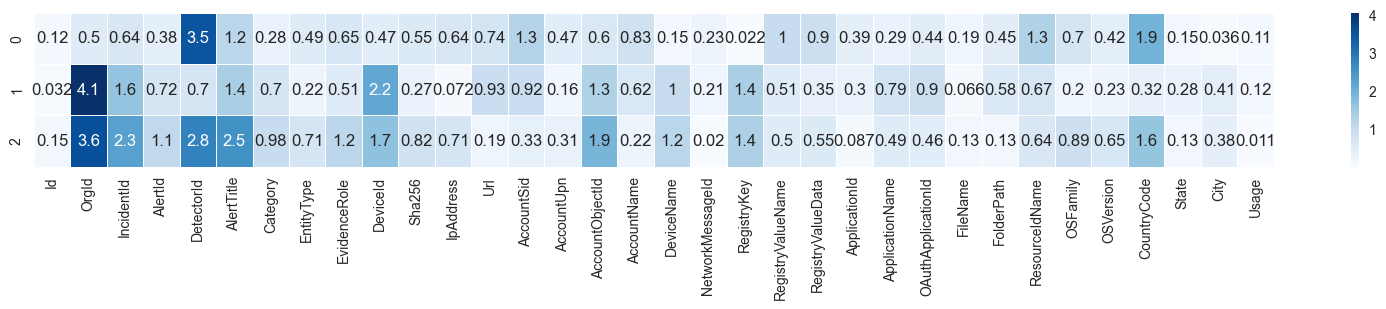

In [70]:
print('Coefs:')
coefs = pd.DataFrame(lr_gs.best_estimator_.coef_)
coefs.columns = X_train.columns

plt.figure(figsize=(20,2));
sns.heatmap(coefs.abs(),annot=True, linewidths=.5,cbar=True,xticklabels=True, cmap='Blues', annot_kws={'size':12});

In [71]:
print(classification_report(y_test, lr_gs.predict(X_test), target_names=target_names))
results_df = save_results(lr_gs, X_test, y_test, 'Logistic', results_df)

                precision    recall  f1-score   support

BenignPositive       0.47      1.00      0.64      1268
 FalsePositive       0.57      0.01      0.02       653
  TruePositive       0.86      0.26      0.40      1079

      accuracy                           0.52      3000
     macro avg       0.64      0.42      0.35      3000
  weighted avg       0.63      0.52      0.42      3000



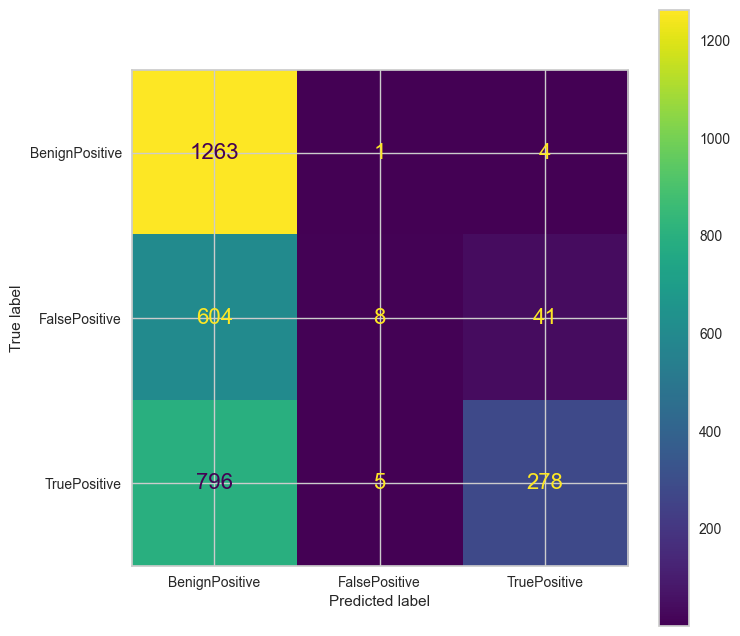

In [72]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(lr_gs, X_test,y_test, display_labels=target_names, ax=plt.subplot());


Feature Importances (Absolute Coefficients):
                    BenignPositive  FalsePositive  TruePositive
Id                           0.121          0.032         0.153
OrgId                        0.497          4.063         3.566
IncidentId                   0.637          1.626         2.263
AlertId                      0.383          0.715         1.098
DetectorId                   3.487          0.695         2.792
AlertTitle                   1.151          1.382         2.533
Category                     0.283          0.696         0.979
EntityType                   0.493          0.222         0.715
EvidenceRole                 0.645          0.505         1.151
DeviceId                     0.469          2.151         1.682
Sha256                       0.552          0.265         0.817
IpAddress                    0.639          0.072         0.711
Url                          0.740          0.926         0.187
AccountSid                   1.255          0.924         

<Figure size 1200x800 with 0 Axes>

<Axes: >

Text(0.5, 0, 'Absolute Coefficient Value')

Text(0.5, 1.0, 'Feature Importances for Each Class in Logistic Regression')

<Figure size 1200x800 with 0 Axes>

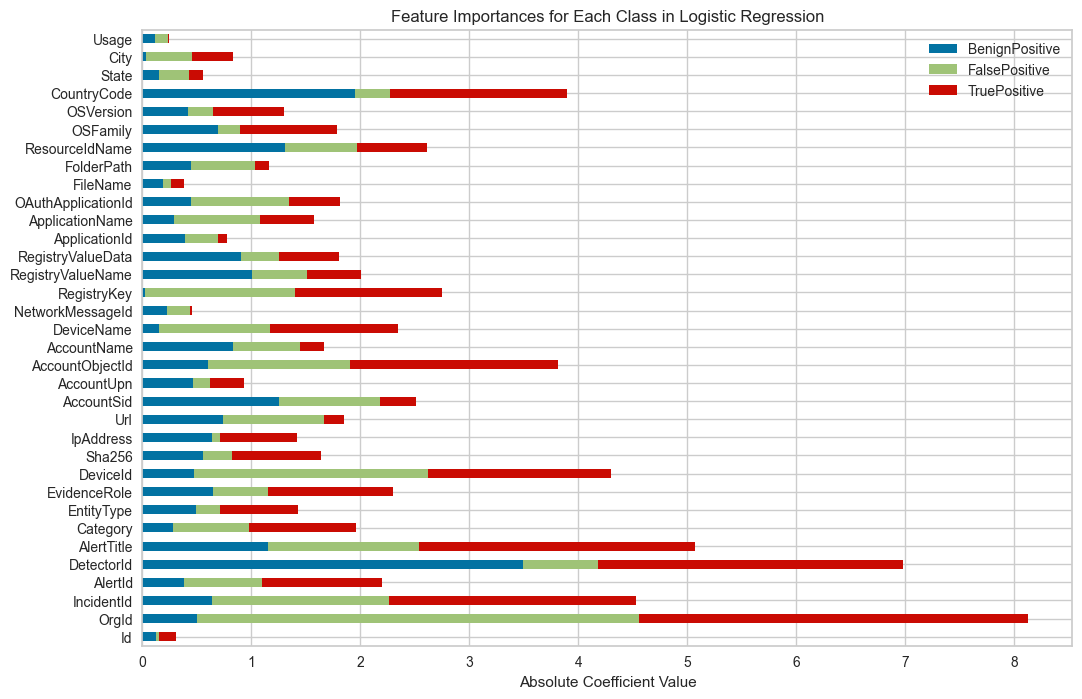

In [73]:
coef = lr_gs.best_estimator_.coef_  
feature_importance = pd.DataFrame(coef.T, index=X_train.columns, columns=target_names)
feature_importance_abs = feature_importance.abs()
print("\nFeature Importances (Absolute Coefficients):")
print(feature_importance_abs)

plt.figure(figsize=(12, 8))
feature_importance_abs.plot(kind='barh', stacked=True, figsize=(12, 8))
plt.xlabel('Absolute Coefficient Value')
plt.title('Feature Importances for Each Class in Logistic Regression')
plt.show()


Feature Importances (Permutation) for Logistic Regression:
                    importance
CountryCode          6.493e-02
IncidentId           9.600e-03
AlertId              6.533e-03
EntityType           5.333e-03
IpAddress            4.067e-03
OrgId                2.933e-03
Sha256               2.467e-03
AlertTitle           2.133e-03
DeviceName           2.000e-03
FolderPath           1.667e-03
FileName             1.600e-03
DetectorId           1.533e-03
Url                  1.267e-03
Id                   1.133e-03
NetworkMessageId     8.000e-04
Usage                5.333e-04
State                5.333e-04
OSVersion            5.333e-04
RegistryValueName    1.333e-04
RegistryValueData    1.333e-04
OAuthApplicationId   0.000e+00
ResourceIdName       0.000e+00
RegistryKey         -2.220e-17
ApplicationName     -2.667e-04
ApplicationId       -3.333e-04
OSFamily            -1.200e-03
Category            -1.333e-03
DeviceId            -2.867e-03
EvidenceRole        -3.467e-03
AccountUpn

<Figure size 1200x800 with 0 Axes>

<BarContainer object of 34 artists>

Text(0.5, 0, 'Permutation Importance')

Text(0, 0.5, 'Feature')

Text(0.5, 1.0, 'Feature Importances from Logistic Regression (Permutation Importance)')

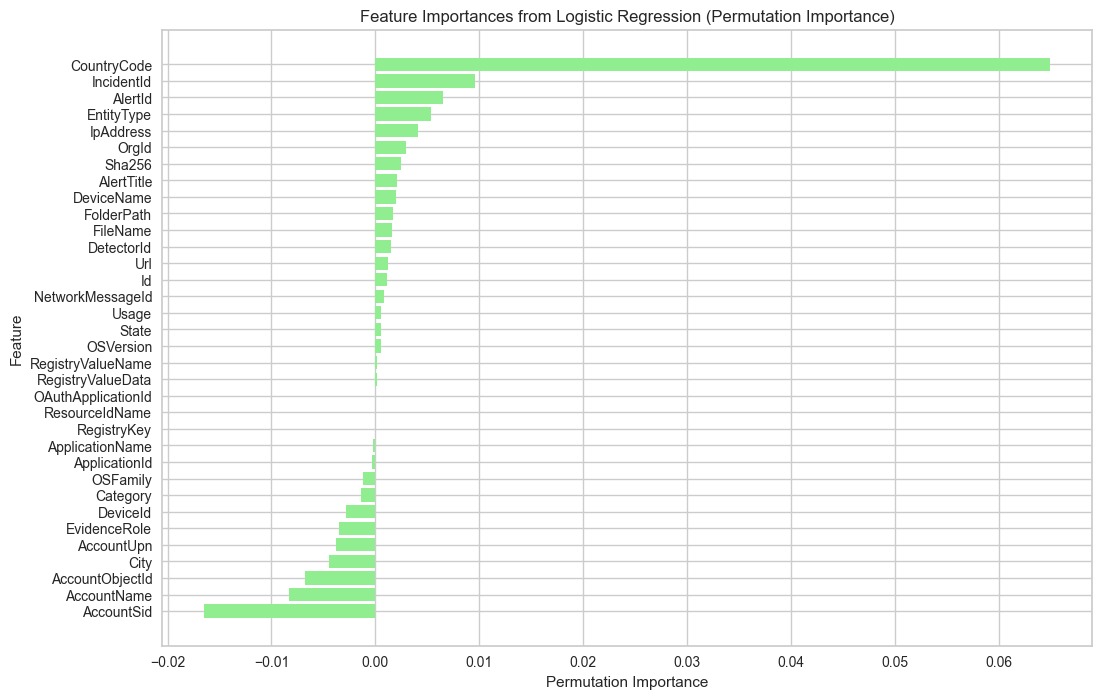

In [74]:
pi = permutation_importance(lr_gs.best_estimator_, X_test, y_test, n_jobs=-1, random_state=0)
feature_importance_lr = pd.DataFrame({'importance': pi.importances_mean}, index=X_test.columns)
feature_importance_lr = feature_importance_lr.sort_values(by="importance", ascending=False)

print("\nFeature Importances (Permutation) for Logistic Regression:")
print(feature_importance_lr)

plt.figure(figsize=(12, 8))
plt.barh(feature_importance_lr.index, feature_importance_lr["importance"], color="lightgreen")
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
plt.xlabel("Permutation Importance")
plt.ylabel("Feature")
plt.title("Feature Importances from Logistic Regression (Permutation Importance)")
plt.show()

### K-nearest neighbours

[EXPLICATION OF WHY K-nearest neighbours]

In [75]:
scaler = MinMaxScaler()

X_train_s = X_train
X_test_s = X_test

In [76]:
knn =  KNeighborsClassifier()
param = {'n_neighbors':[1, 3, 5, 7, 11, 15, 17, 19, 21],
          'weights':['distance', 'uniform'],
          'metric': ['l2', 'l1', 'cosine']}

knn_gs =  GridSearchCV(knn,param,cv=cv, n_jobs=-1)
knn_gs.fit(X_train_s, y_train);

In [77]:
show_html(pd.DataFrame(knn_gs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
24,"{'metric': 'l1', 'n_neighbors': 7, 'weights': 'distance'}",0.698,1
26,"{'metric': 'l1', 'n_neighbors': 11, 'weights': 'distance'}",0.697,2
22,"{'metric': 'l1', 'n_neighbors': 5, 'weights': 'distance'}",0.694,3
30,"{'metric': 'l1', 'n_neighbors': 17, 'weights': 'distance'}",0.694,4
28,"{'metric': 'l1', 'n_neighbors': 15, 'weights': 'distance'}",0.693,5


In [78]:
print(classification_report(y_test, knn_gs.predict(X_test_s), target_names=target_names))
results_df = save_results(knn_gs, X_test_s, y_test, 'KNN', results_df)

                precision    recall  f1-score   support

BenignPositive       0.68      0.78      0.73      1268
 FalsePositive       0.62      0.48      0.54       653
  TruePositive       0.75      0.72      0.73      1079

      accuracy                           0.69      3000
     macro avg       0.68      0.66      0.67      3000
  weighted avg       0.69      0.69      0.69      3000



Podemos ver también cierto desbalance en sus predicciones

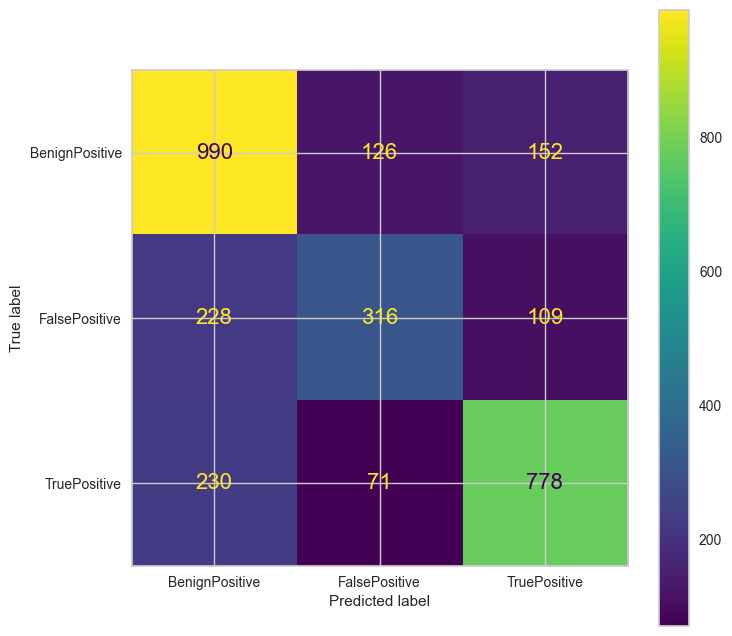

In [79]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(knn_gs, X_test_s,y_test, display_labels=target_names, ax=plt.subplot());

In [80]:
results_df.sort_values(by=['test acc'], ascending=False)

,train XV acc,test acc,precision score (M),recall score (M),f1 score (M)
KNN,0.698,0.695,0.683,0.662,0.669
MNB,NaN,0.555,0.411,0.459,0.401
Logistic,0.622,0.516,0.635,0.422,0.354
GNB,NaN,0.423,0.141,0.333,0.198



Feature Importances (Permutation) for KNN:
                    importance
EvidenceRole         6.393e-02
EntityType           4.973e-02
IncidentId           4.220e-02
IpAddress            3.847e-02
Category             3.553e-02
Id                   3.480e-02
AlertId              3.340e-02
Usage                2.027e-02
CountryCode          1.453e-02
DeviceName           1.433e-02
NetworkMessageId     1.140e-02
FileName             7.333e-03
DeviceId             6.200e-03
OrgId                5.800e-03
Sha256               5.533e-03
FolderPath           4.333e-03
DetectorId           3.800e-03
AlertTitle           3.733e-03
AccountUpn           2.467e-03
RegistryKey          2.333e-03
ApplicationId        1.400e-03
ApplicationName      7.333e-04
OSVersion            7.333e-04
RegistryValueData    6.667e-04
State                6.667e-04
OSFamily             4.000e-04
RegistryValueName    3.333e-04
City                 2.000e-04
ResourceIdName       0.000e+00
OAuthApplicationId  -3.333

<Figure size 1200x800 with 0 Axes>

<BarContainer object of 34 artists>

Text(0.5, 0, 'Permutation Importance')

Text(0, 0.5, 'Feature')

Text(0.5, 1.0, 'Feature Importances from KNN (Permutation Importance)')

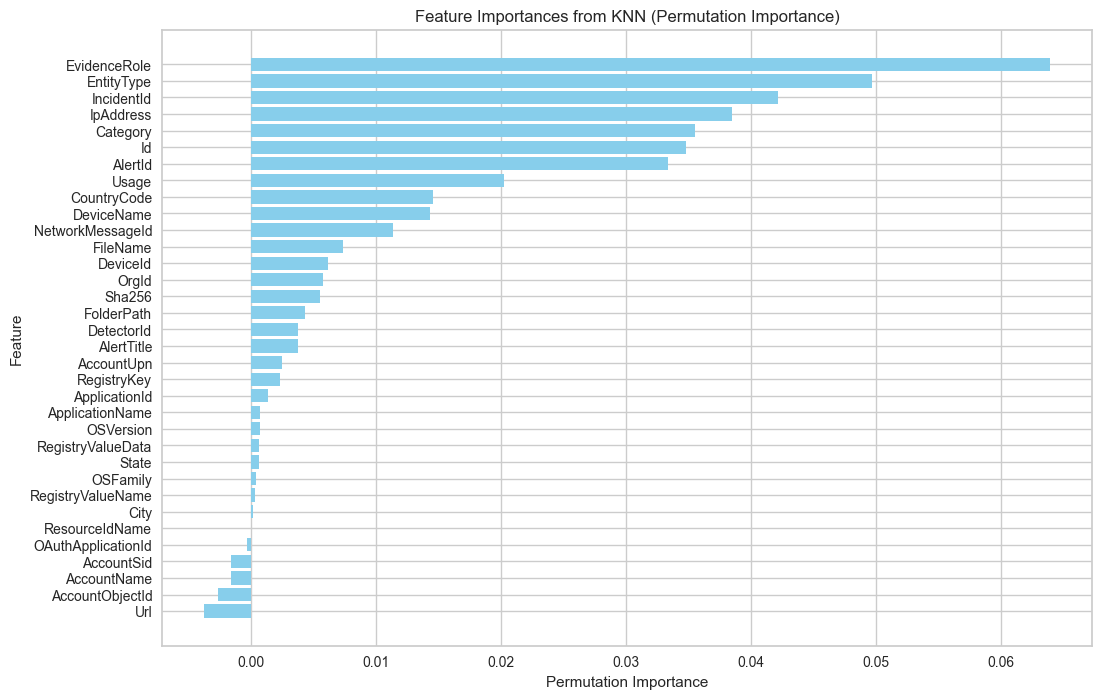

In [81]:
pi = permutation_importance(knn_gs.best_estimator_, X_test, y_test, n_jobs=-1, random_state=0)

feature_importance_knn = pd.DataFrame({'importance': pi.importances_mean}, index=X_test.columns)
feature_importance_knn = feature_importance_knn.sort_values(by="importance", ascending=False)

print("\nFeature Importances (Permutation) for KNN:")
print(feature_importance_knn)

plt.figure(figsize=(12, 8))
plt.barh(feature_importance_knn.index, feature_importance_knn["importance"], color="skyblue")
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
plt.xlabel("Permutation Importance")
plt.ylabel("Feature")
plt.title("Feature Importances from KNN (Permutation Importance)")
plt.show()


## Non-Linear Methods

### Random Forest Tree

In [82]:
param = {'n_estimators': [5,10,25,40, 50, 75,100, 200],
         'criterion':['gini', 'entropy'],
         'max_depth':[None, 1, 2, 3,  5,  8, 9,10,15],
         'min_samples_leaf':[1,2,3,5,10]}
iter = 40
rf =  RandomForestClassifier(random_state=0)
rf_bs =  BayesSearchCV(rf,param,n_iter=iter, cv=cv, n_jobs=-1, refit=True, random_state=0)

In [83]:
rf_bs.fit(X_train, y_train);

In [84]:
show_html(pd.DataFrame(rf_bs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
11,"{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 200}",0.828,1
26,"{'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 200}",0.825,2
16,"{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 100}",0.824,3
15,"{'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 50}",0.823,4
25,"{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 2, 'n_estimators': 200}",0.820,5


In [85]:
print(classification_report(y_test, rf_bs.predict(X_test), target_names=target_names))
results_df = save_results(rf_bs, X_test, y_test, 'Random Forest', results_df)

                precision    recall  f1-score   support

BenignPositive       0.76      0.94      0.84      1268
 FalsePositive       0.88      0.65      0.74       653
  TruePositive       0.91      0.80      0.86      1079

      accuracy                           0.83      3000
     macro avg       0.85      0.80      0.81      3000
  weighted avg       0.84      0.83      0.83      3000



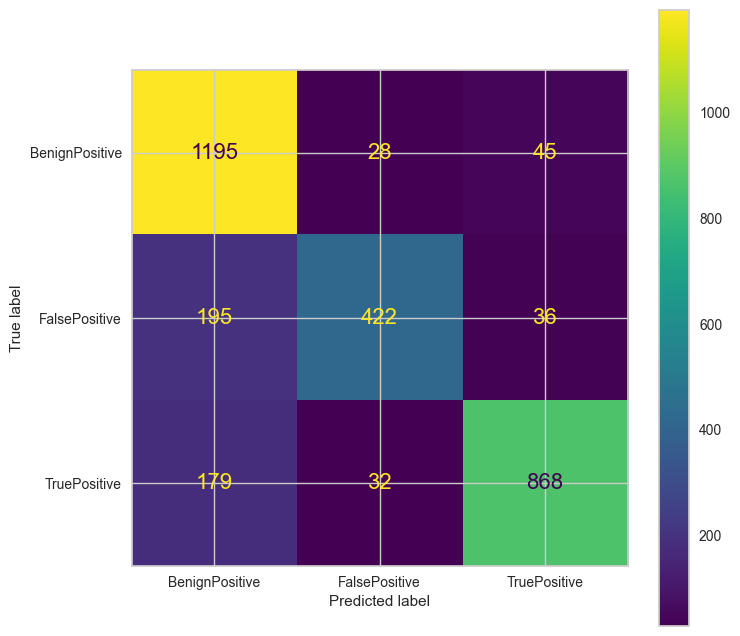

In [86]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(rf_bs, X_test,y_test, ax=plt.subplot());

In [87]:
importances = pd.DataFrame(rf_bs.best_estimator_.feature_importances_)



Feature Importances (Permutation) for Random Forest:
                    importance
IncidentId           8.973e-02
OrgId                8.493e-02
DetectorId           7.087e-02
AlertId              5.020e-02
AlertTitle           3.547e-02
Category             2.547e-02
IpAddress            6.333e-03
Usage                5.533e-03
AccountUpn           4.733e-03
Id                   4.667e-03
CountryCode          4.467e-03
EntityType           3.933e-03
EvidenceRole         3.400e-03
DeviceName           3.067e-03
NetworkMessageId     3.067e-03
Url                  2.933e-03
FileName             1.733e-03
AccountObjectId      1.467e-03
FolderPath           1.133e-03
Sha256               1.133e-03
OSVersion            9.333e-04
OSFamily             6.667e-04
State                6.667e-05
RegistryValueName    0.000e+00
ResourceIdName       0.000e+00
RegistryValueData    0.000e+00
OAuthApplicationId   0.000e+00
RegistryKey         -6.667e-05
DeviceId            -2.000e-04
ApplicationName 

<Figure size 1200x800 with 0 Axes>

<BarContainer object of 34 artists>

Text(0.5, 0, 'Permutation Importance')

Text(0, 0.5, 'Feature')

Text(0.5, 1.0, 'Feature Importances from Random Forest (Permutation Importance)')

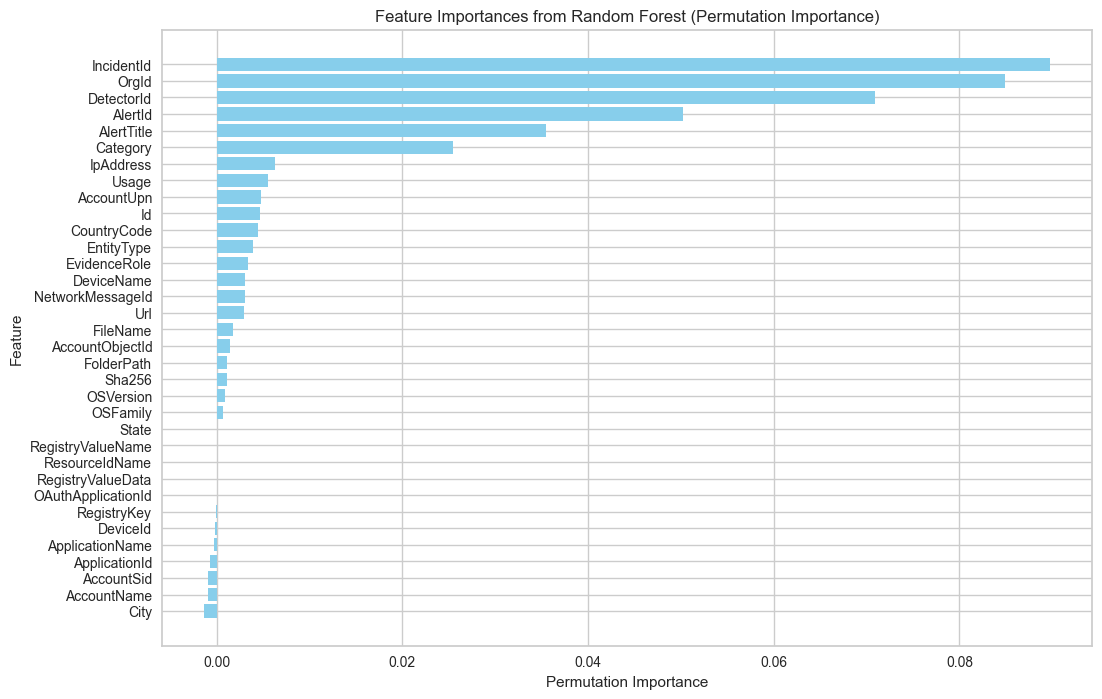

In [88]:
pi = permutation_importance(rf_bs.best_estimator_, X_test, y_test, n_jobs=-1, random_state=0)

feature_importance_rf = pd.DataFrame({'importance': pi.importances_mean}, index=X_test.columns)
feature_importance_rf = feature_importance_rf.sort_values(by="importance", ascending=False)

print("\nFeature Importances (Permutation) for Random Forest:")
print(feature_importance_rf)

plt.figure(figsize=(12, 8))
plt.barh(feature_importance_rf.index, feature_importance_rf["importance"], color="skyblue")
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
plt.xlabel("Permutation Importance")
plt.ylabel("Feature")
plt.title("Feature Importances from Random Forest (Permutation Importance)")
plt.show()

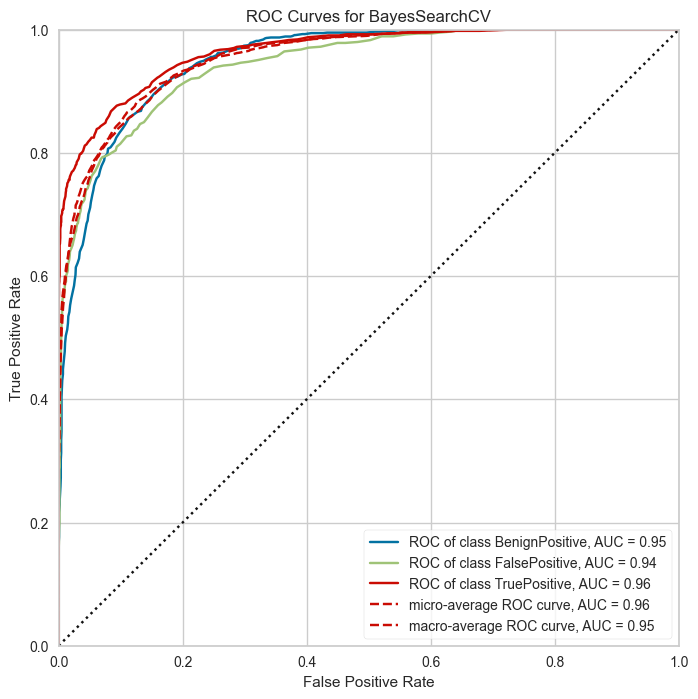

In [89]:
plt.figure(figsize=(8,8));
roc_auc(rf_bs, X_train, y_train, X_test, y_test, classes=target_names);

### SVM RBF KERNEL

In [90]:
param = {'C':10**np.linspace(-3,3,101), 'gamma':['scale','auto'], 'probability': [True]}

rbsvc =  SVC(kernel='rbf', max_iter=25000, random_state=0)
rbsvc_gs = BayesSearchCV(rbsvc,param,n_iter=niter, cv=cv, n_jobs=-1, refit=True, random_state=0)

In [109]:
rbsvc_gs.fit(X_train, y_train);

In [92]:
show_html(pd.DataFrame(rbsvc_gs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
10,"{'C': 660.6934480075951, 'gamma': 'scale', 'probability': True}",0.674,1
6,"{'C': 660.6934480075951, 'gamma': 'auto', 'probability': True}",0.667,2
14,"{'C': 10.471285480508985, 'gamma': 'scale', 'probability': True}",0.666,3
13,"{'C': 4.570881896148746, 'gamma': 'scale', 'probability': True}",0.655,4
5,"{'C': 109.64781961431851, 'gamma': 'auto', 'probability': True}",0.653,5


In [93]:
print(classification_report(y_test, rbsvc_gs.predict(X_test), target_names=target_names))
results_df = save_results(rbsvc_gs, X_test, y_test, 'RBF SVM binary', results_df)

                precision    recall  f1-score   support

BenignPositive       0.53      0.95      0.68      1268
 FalsePositive       0.86      0.09      0.17       653
  TruePositive       0.85      0.52      0.64      1079

      accuracy                           0.61      3000
     macro avg       0.75      0.52      0.50      3000
  weighted avg       0.72      0.61      0.56      3000



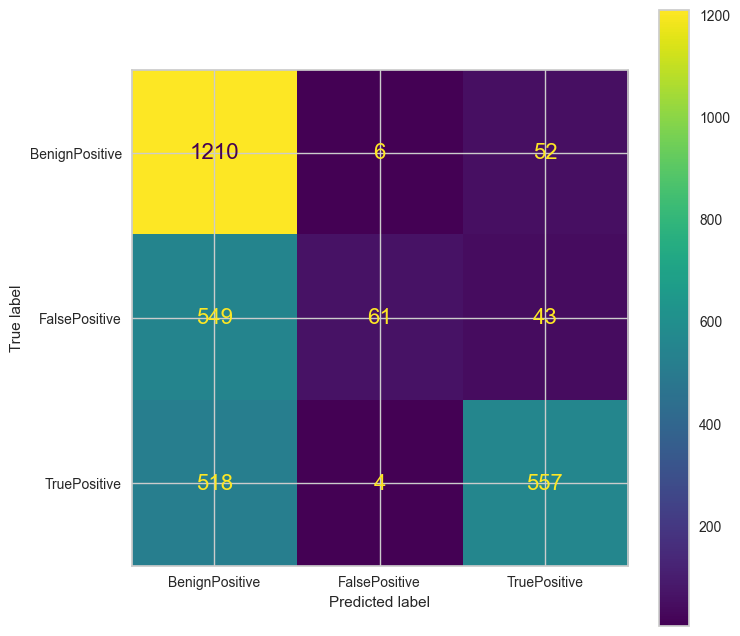

In [94]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(rbsvc_gs, X_test, y_test, display_labels=target_names, ax=plt.subplot());

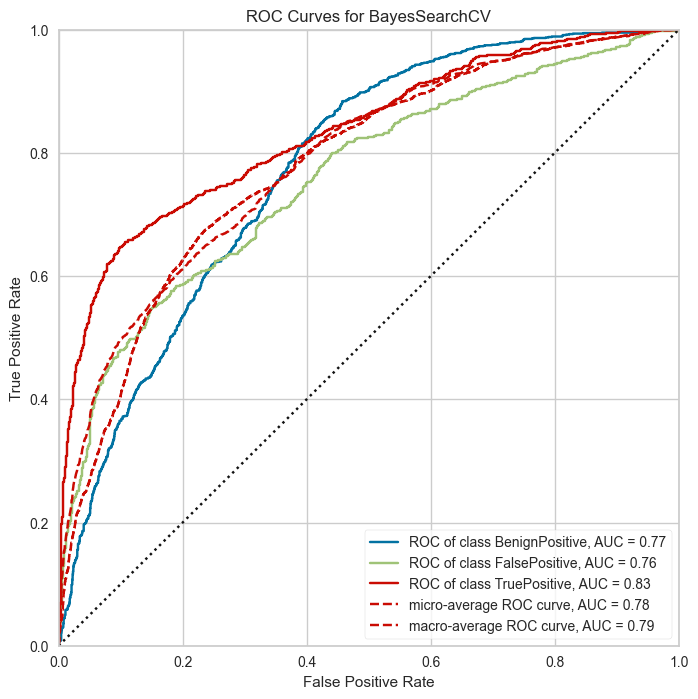

In [95]:
plt.figure(figsize=(8,8));
roc_auc(rbsvc_gs, X_train, y_train, X_test, y_test, classes=target_names);


Feature Importances (Permutation) for SVM with RBF Kernel:
                    importance
EntityType           8.353e-02
AccountObjectId      7.667e-02
CountryCode          5.253e-02
IncidentId           4.633e-02
AccountName          4.387e-02
AccountSid           4.180e-02
AccountUpn           3.887e-02
State                3.440e-02
AlertId              3.340e-02
EvidenceRole         2.680e-02
Category             1.693e-02
FileName             1.533e-02
Sha256               1.447e-02
FolderPath           1.200e-02
OrgId                1.140e-02
DeviceId             1.113e-02
City                 1.007e-02
Id                   9.333e-03
IpAddress            7.267e-03
AlertTitle           5.467e-03
DeviceName           4.267e-03
NetworkMessageId     4.067e-03
Url                  3.867e-03
OSVersion            2.267e-03
OSFamily             1.667e-03
ApplicationId        1.200e-03
ApplicationName      1.000e-03
RegistryValueName    6.667e-04
DetectorId           4.000e-04
RegistryKe

<Figure size 1200x800 with 0 Axes>

<BarContainer object of 34 artists>

Text(0.5, 0, 'Permutation Importance')

Text(0, 0.5, 'Feature')

Text(0.5, 1.0, 'Feature Importances from SVM with RBF Kernel (Permutation Importance)')

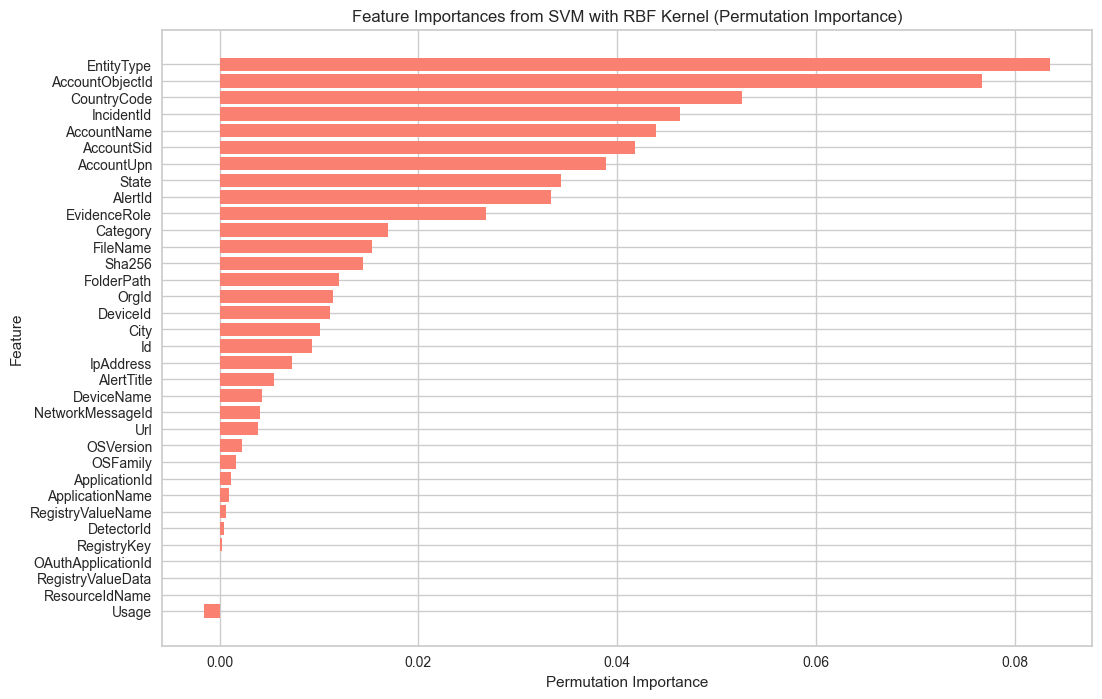

In [96]:
pi = permutation_importance(rbsvc_gs.best_estimator_, X_test, y_test, n_jobs=-1, random_state=0)

feature_importance_svm_rbf = pd.DataFrame({'importance': pi.importances_mean}, index=X_test.columns)
feature_importance_svm_rbf = feature_importance_svm_rbf.sort_values(by="importance", ascending=False)

print("\nFeature Importances (Permutation) for SVM with RBF Kernel:")
print(feature_importance_svm_rbf)

plt.figure(figsize=(12, 8))
plt.barh(feature_importance_svm_rbf.index, feature_importance_svm_rbf["importance"], color="salmon")
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
plt.xlabel("Permutation Importance")
plt.ylabel("Feature")
plt.title("Feature Importances from SVM with RBF Kernel (Permutation Importance)")
plt.show()

### Gradient Boosting

In [97]:
param = {'n_estimators': [5,10,25,40, 50, 75,100, 200],
         'loss':['log_loss'], # exponential does not work
         'criterion':['friedman_mse', 'squared_error'],
         'max_depth':[None, 1, 2, 3,  5,  8, 9,10,15],
         'min_samples_leaf':[1,2,3,5,10],
         'learning_rate':[0.1,0.5, 1,3, 5, 10, 15]}
iter = 40
gb =  GradientBoostingClassifier(random_state=0,n_iter_no_change=5)
gb_bs =  BayesSearchCV(gb,param,n_iter=iter, cv=cv, n_jobs=-1, refit=True, random_state=0)

In [98]:
gb_bs.fit(X_train, y_train);

In [99]:
show_html(pd.DataFrame(gb_bs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
39,"{'criterion': 'friedman_mse', 'learning_rate': 1, 'loss': 'log_loss', 'max_depth': None, 'min_samples_leaf': 5, 'n_estimators': 5}",0.844,1
15,"{'criterion': 'friedman_mse', 'learning_rate': 3, 'loss': 'log_loss', 'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 5}",0.833,2
14,"{'criterion': 'friedman_mse', 'learning_rate': 3, 'loss': 'log_loss', 'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 40}",0.830,3
13,"{'criterion': 'friedman_mse', 'learning_rate': 3, 'loss': 'log_loss', 'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 100}",0.830,3
27,"{'criterion': 'friedman_mse', 'learning_rate': 3, 'loss': 'log_loss', 'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 75}",0.830,3


In [100]:
print(classification_report(y_test, gb_bs.predict(X_test), target_names=target_names))
results_df = save_results(gb_bs, X_test, y_test, 'Random Forest', results_df)

                precision    recall  f1-score   support

BenignPositive       0.79      0.87      0.83      1268
 FalsePositive       0.79      0.68      0.73       653
  TruePositive       0.88      0.84      0.86      1079

      accuracy                           0.82      3000
     macro avg       0.82      0.80      0.81      3000
  weighted avg       0.82      0.82      0.82      3000



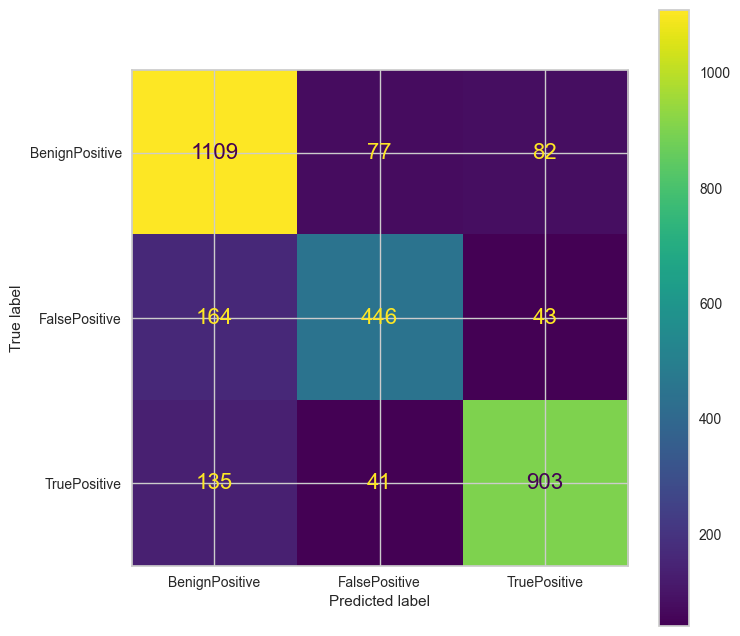

In [101]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(gb_bs, X_test,y_test, ax=plt.subplot());

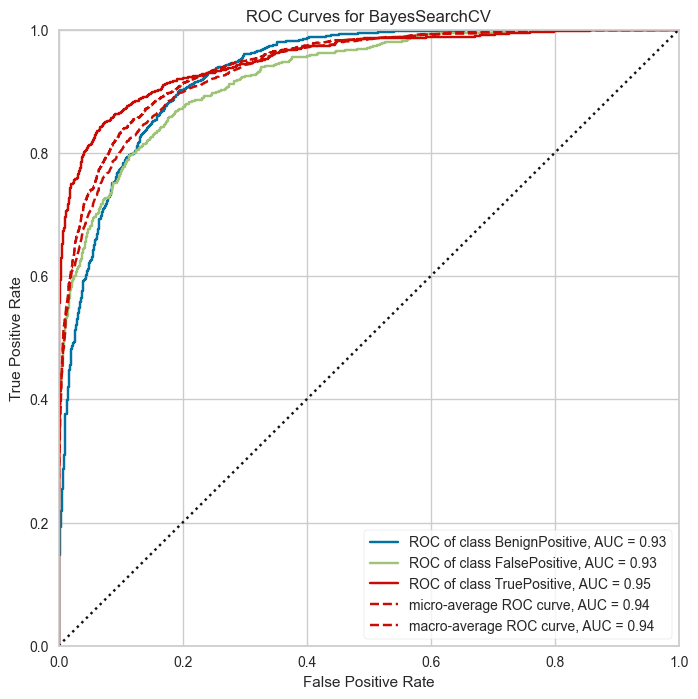

In [102]:
plt.figure(figsize=(8,8));
roc_auc(gb_bs, X_train, y_train, X_test, y_test, classes=target_names);


Feature Importances (Permutation) for Gradient Boosting:
                    importance
OrgId                1.744e-01
IncidentId           1.401e-01
DetectorId           9.553e-02
AlertId              7.713e-02
AlertTitle           7.467e-02
Category             4.087e-02
AccountUpn           8.600e-03
IpAddress            8.400e-03
Id                   6.467e-03
EntityType           4.933e-03
AccountObjectId      3.333e-03
CountryCode          2.333e-03
AccountSid           1.600e-03
DeviceName           1.333e-03
FileName             1.133e-03
NetworkMessageId     1.067e-03
Sha256               1.000e-03
AccountName          6.667e-04
Usage                6.667e-04
ApplicationName      6.000e-04
State                4.667e-04
OSFamily             4.667e-04
ApplicationId        2.667e-04
OAuthApplicationId   0.000e+00
RegistryValueName    0.000e+00
RegistryKey          0.000e+00
ResourceIdName       0.000e+00
OSVersion            0.000e+00
City                 0.000e+00
RegistryValu

<Figure size 1200x800 with 0 Axes>

<BarContainer object of 34 artists>

Text(0.5, 0, 'Permutation Importance')

Text(0, 0.5, 'Feature')

Text(0.5, 1.0, 'Feature Importances from Gradient Boosting (Permutation Importance)')

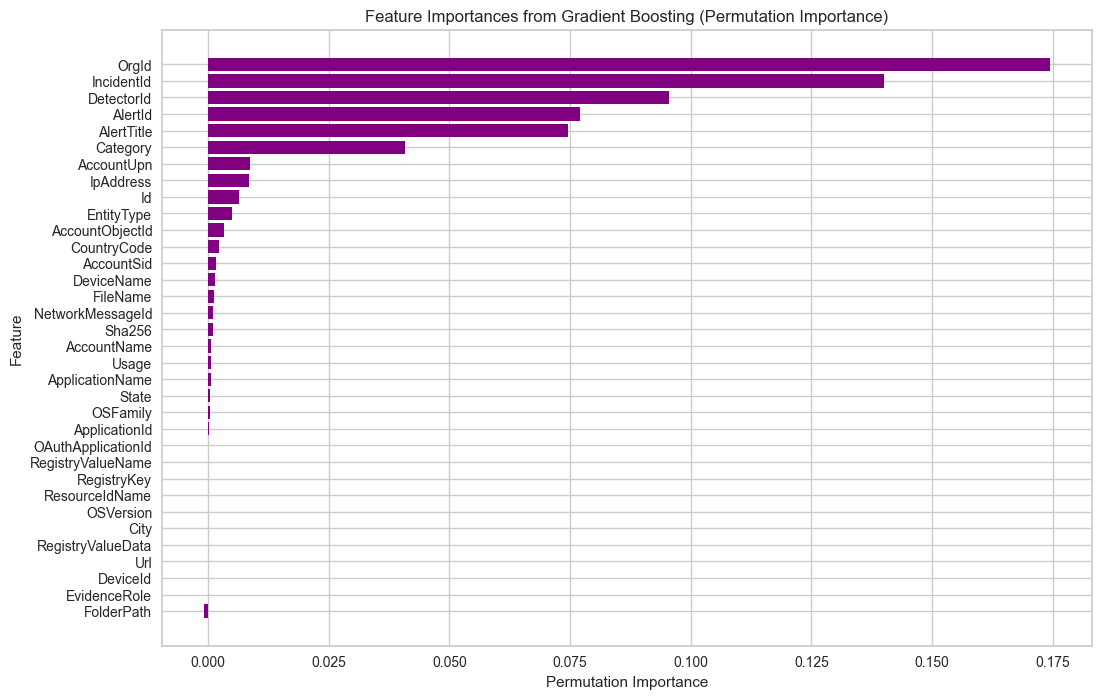

In [103]:
pi = permutation_importance(gb_bs.best_estimator_, X_test, y_test, n_jobs=-1, random_state=0)

feature_importance_gb = pd.DataFrame({'importance': pi.importances_mean}, index=X_test.columns)
feature_importance_gb = feature_importance_gb.sort_values(by="importance", ascending=False)

print("\nFeature Importances (Permutation) for Gradient Boosting:")
print(feature_importance_gb)

plt.figure(figsize=(12, 8))
plt.barh(feature_importance_gb.index, feature_importance_gb["importance"], color="purple")
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
plt.xlabel("Permutation Importance")
plt.ylabel("Feature")
plt.title("Feature Importances from Gradient Boosting (Permutation Importance)")
plt.show()

In [104]:
from joblib import dump, load

In [105]:
dump(gb_bs, 'gradient_boosting_model.joblib')

['gradient_boosting_model.joblib']

In [106]:
dump(rf_bs, 'random_forest_model.joblib')
dump(rbsvc_gs, 'SVM_RBF_model.joblib')


['random_forest_model.joblib']

['SVM_RBF_model.joblib']